# **📊 Logistic Regression from Scratch — Polynomial Feature Analysis**

In [26]:
import pandas as pd
import numpy as np
from itertools import combinations_with_replacement
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

### Functions

In [46]:
def save_weights_to_npy(w, b, std, mean, weight_file="weights_poly_trad.npy"
                        , bias_file="bias_poly_trad.npy"
                        , std_file="std_poly_trad.npy"
                        , mean_file="mean_poly_trad.npy"):
    np.save(weight_file, w)
    np.save(bias_file, np.array([b]))
    np.save(std_file, std)
    np.save(mean_file, mean)

def polynomial_features(X, degree):
    """
    Generate polynomial features for input matrix X up to a given degree.
    Parameters:
        X: numpy array of shape (m, n)
        degree: int, highest polynomial degree to generate
    Returns:
        X_poly: numpy array of shape (m, num_features)
    """
    m, n = X.shape
    features = [np.ones((m, 1))]  # Bias term: degree 0
    
    for deg in range(1, degree + 1):
        for combo in combinations_with_replacement(range(n), deg):
            # Multiply columns based on index combo
            col = np.ones(m)
            for idx in combo:
                col *= X[:, idx]
            features.append(col.reshape(-1, 1))
    
    return np.hstack(features)

def predict(X, w, b, Threshold=0.22):
    probs = predict_prob(X, w, b)
    return (probs >= Threshold).astype(int)

def predict_prob(X, w, b):
    z = np.dot(X, w) + b
    z = np.clip(z, -500, 500)  # Prevent exp overflow
    return sigmoid(z)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, w, b):
    m = X.shape[0]
    f_wb = predict_prob(X, w, b)
    f_wb = np.clip(f_wb, 1e-15, 1 - 1e-15)  # Prevent log(0)
    cost = (-1/m) * np.sum(y * np.log(f_wb) + (1 - y) * np.log(1 - f_wb))
    return cost

def compute_gradient(X, y, w, b, L2_reg):
    m = X.shape[0]

    f_wb = predict_prob(X, w, b)
    
    dj_dw = ((1/m) * np.dot(X.T, (f_wb - y))) + ((L2_reg/m) * w)  # L2 regularization term
    dj_db = (1/m) * np.sum(f_wb - y)
    
    return dj_dw, dj_db

def gradient_descent(lr, x, y, w, b, L2_reg, method, previous_cost, threshold, max_iters):
    
    m = x.shape[0]
    iters = 0
    L2_reg = L2_reg

    #Logs for tracking
    cost_log = []
    iteration_log = []
    weight_log = []
    bias_log = []

    method = method.lower()

    if method == 'adam':
        
        v_w, v_b, s_w, s_b = np.zeros_like(w), 0.0, np.zeros_like(w), 0.0
        beta1 = 0.9
        beta2 = 0.999
        epsilon = 1e-8

        while True:

            dj_dw, dj_db = compute_gradient(x, y, w, b, L2_reg)

            v_w_corrected, v_b_corrected, s_w_corrected, s_b_corrected, v_w, v_b, s_w, s_b = compute_adam_update(dj_dw, dj_db, v_w, v_b, s_w, s_b, beta1, beta2, iters)
            
            w -= lr * v_w_corrected / (np.sqrt(s_w_corrected) + epsilon)
            b -= lr * v_b_corrected / (np.sqrt(s_b_corrected) + epsilon)
            
            current_cost = compute_cost(x, y, w, b)

            # if iters % 100 == 0:
            #     print(f"Iteration {iters} | Cost: {current_cost:.5f} | b: {b:.5f}")
            #     #Log the cost, iteration, weights, and bias
            #     if iters < 1001 and iters % 100 == 0 and iters > 1:
            #         cost_log.append(current_cost)
            #         iteration_log.append(iters)
            #         weight_log.append(w.flatten().tolist())  # Save as list
            #         bias_log.append(b)
            #     elif iters < 10000 and iters > 1001 and iters % 500 == 0:
            #         cost_log.append(current_cost)
            #         iteration_log.append(iters)
            #         weight_log.append(w.flatten().tolist())  # Save as list
            #         bias_log.append(b)

            if abs(current_cost - previous_cost) < threshold:
                print(f"Converged in {iters} iterations.")
                break
            
            previous_cost = current_cost
            iters += 1

            if iters >= max_iters:
                print("Stopped: Max iterations reached.")
                break


    elif method == 'vanilla' or method == 'gd':
        while True:
            
            dj_dw, dj_db = compute_gradient(x, y, w, b, L2_reg)

            w = w - (lr/m)*(dj_dw)
            b = b - (lr/m)*(dj_db)

            current_cost = compute_cost(x, y, w, b)

            # if iters % 100 == 0:
            #     print(f"Iteration {iters} | Cost: {current_cost:.5f} | w: {w.ravel()} | b: {b:.5f}")
                
                # Log the cost, iteration, weights, and bias
                # if iters < 1001 and iters % 100 == 0 and iters > 1:
                #     cost_log.append(current_cost)
                #     iteration_log.append(iters)
                #     weight_log.append(w.flatten().tolist())  # Save as list
                #     bias_log.append(b)
                # elif iters < 10000 and iters > 1001 and iters % 1000 == 0:
                #     cost_log.append(current_cost)
                #     iteration_log.append(iters)
                #     weight_log.append(w.flatten().tolist())  # Save as list
                #     bias_log.append(b)
             
            if abs(current_cost-previous_cost) < threshold:
                print(f"Converged in {iters} iterations.")
                break

            previous_cost = current_cost
            iters += 1
            if iters >= max_iters:
                print("Stopped: Max iterations reached.")
                break

    else:
        raise ValueError(f"Unsupported optimization method: {method}")

    return w , b #,cost_log , iteration_log , weight_log , bias_log

def compute_adam_update(dj_dw, dj_db, v_w, v_b, s_w, s_b, beta1 , beta2  , iters):
    # Update biased first moment estimates
    v_w = beta1 * v_w + (1 - beta1) * dj_dw
    v_b = beta1 * v_b + (1 - beta1) * dj_db

    # Update biased second moment estimates
    s_w = beta2 * s_w + (1 - beta2) * (dj_dw ** 2)
    s_b = beta2 * s_b + (1 - beta2) * (dj_db ** 2)

    # Compute bias-corrected first moment estimates
    v_w_corrected = v_w / (1 - beta1 ** (iters + 1))
    v_b_corrected = v_b / (1 - beta1 ** (iters + 1))

    # Compute bias-corrected second moment estimates
    s_w_corrected = s_w / (1 - beta2 ** (iters + 1))
    s_b_corrected = s_b / (1 - beta2 ** (iters + 1))

    return v_w_corrected, v_b_corrected, s_w_corrected, s_b_corrected, v_w, v_b, s_w, s_b

def adam_gradient_descent(lr, x, y, w, b, previous_cost, threshold, max_iters):
    m = x.shape[0]
    iters = 0
    cost_log = []
    iteration_log = []
    weight_log = []
    bias_log = []

    # Initialize Adam parameters
    v_w = np.zeros_like(w)
    v_b = 0.0
    s_w = np.zeros_like(w)
    s_b = 0.0
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8

    while True:
        dj_dw, dj_db = compute_gradient(x, y, w, b)

        # Update biased first moment estimates
        v_w = beta1 * v_w + (1 - beta1) * dj_dw
        v_b = beta1 * v_b + (1 - beta1) * dj_db

        # Update biased second moment estimates
        s_w = beta2 * s_w + (1 - beta2) * (dj_dw ** 2)
        s_b = beta2 * s_b + (1 - beta2) * (dj_db ** 2)

        # Compute bias-corrected first moment estimates
        v_w_corrected = v_w / (1 - beta1 ** (iters + 1))
        v_b_corrected = v_b / (1 - beta1 ** (iters + 1))

        # Compute bias-corrected second moment estimates
        s_w_corrected = s_w / (1 - beta2 ** (iters + 1))
        s_b_corrected = s_b / (1 - beta2 ** (iters + 1))

        # Update parameters
        w -= lr * v_w_corrected / (np.sqrt(s_w_corrected) + epsilon)
        b -= lr * v_b_corrected / (np.sqrt(s_b_corrected) + epsilon)

        current_cost = compute_cost(x, y, w, b)

        if iters % 100 == 0:
            print(f"Iteration {iters} | Cost: {current_cost:.5f} | w: {w.ravel()} | b: {b:.5f}")

        if abs(current_cost - previous_cost) < threshold:
            print(f"Converged in {iters} iterations.")
            break

        previous_cost = current_cost

    return w, b
    

### **🛠️ Goal**
We implemented logistic regression from scratch with vectorized NumPy, trained using the Adam optimizer, and evaluated the impact of increasing polynomial degree(upto degree 7) on model performance. The model was trained on standardized features and evaluated on a validation set.


Training with L2 Regularization: 0
Converged in 177 iterations.

 Validation Set Results for Degree 1

📊 Classification Metrics (Validation Set):
Accuracy       : 0.7841
Precision      : 0.6984
Recall         : 0.6984
F1 Score       : 0.6984
Confusion Matrix:
 [[94 19]
 [19 44]]


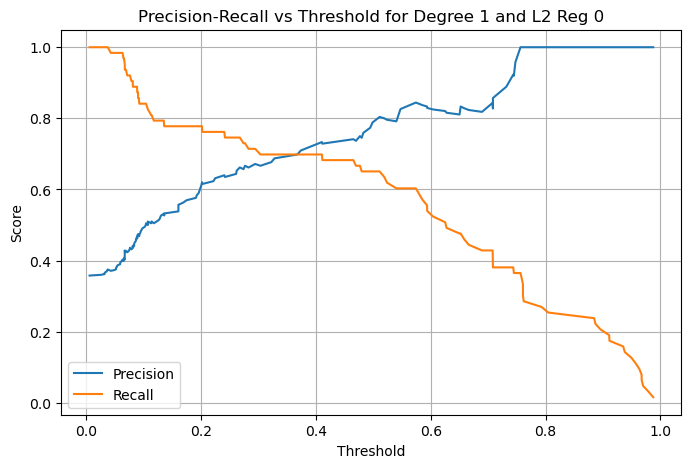

Converged in 4304 iterations.

 Validation Set Results for Degree 2

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8409
Precision      : 0.8070
Recall         : 0.7302
F1 Score       : 0.7667
Confusion Matrix:
 [[102  11]
 [ 17  46]]


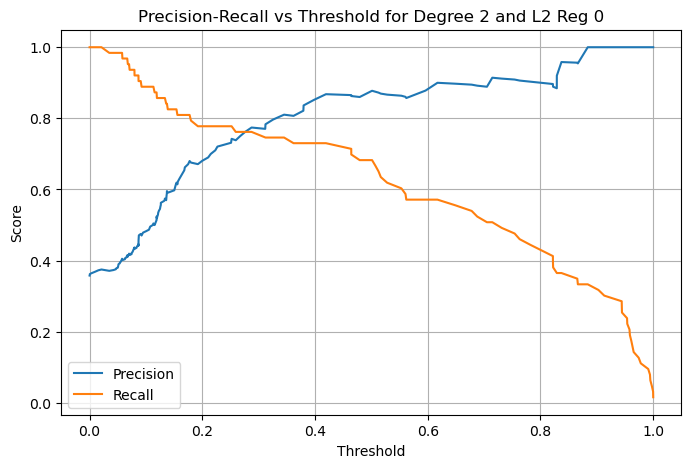

Converged in 5769 iterations.

 Validation Set Results for Degree 3

📊 Classification Metrics (Validation Set):
Accuracy       : 0.7898
Precision      : 0.7407
Recall         : 0.6349
F1 Score       : 0.6838
Confusion Matrix:
 [[99 14]
 [23 40]]


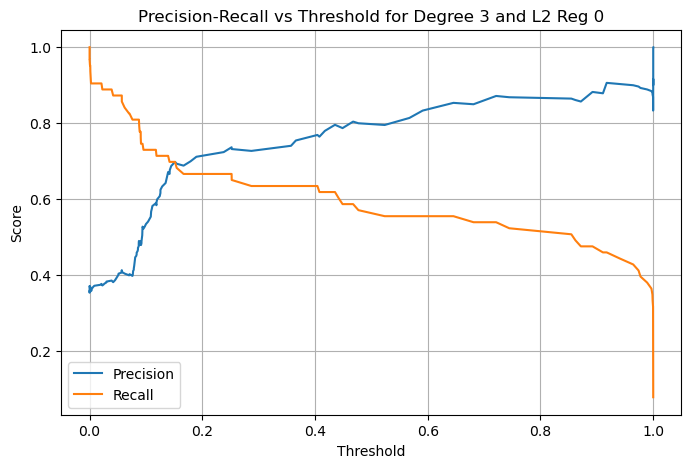

Converged in 2483 iterations.

 Validation Set Results for Degree 4

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8182
Precision      : 0.8039
Recall         : 0.6508
F1 Score       : 0.7193
Confusion Matrix:
 [[103  10]
 [ 22  41]]


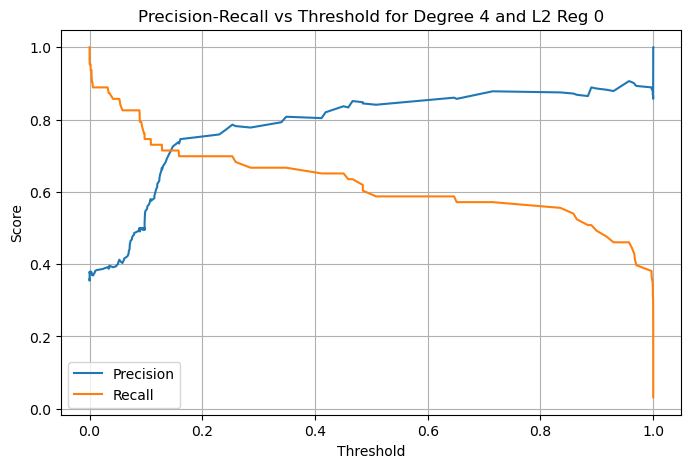

Converged in 1084 iterations.

 Validation Set Results for Degree 5

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8068
Precision      : 0.7736
Recall         : 0.6508
F1 Score       : 0.7069
Confusion Matrix:
 [[101  12]
 [ 22  41]]


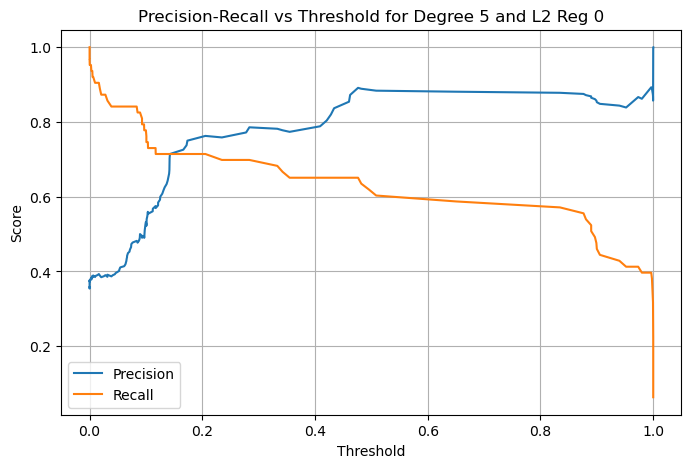

Converged in 1161 iterations.

 Validation Set Results for Degree 6

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8125
Precision      : 0.7778
Recall         : 0.6667
F1 Score       : 0.7179
Confusion Matrix:
 [[101  12]
 [ 21  42]]


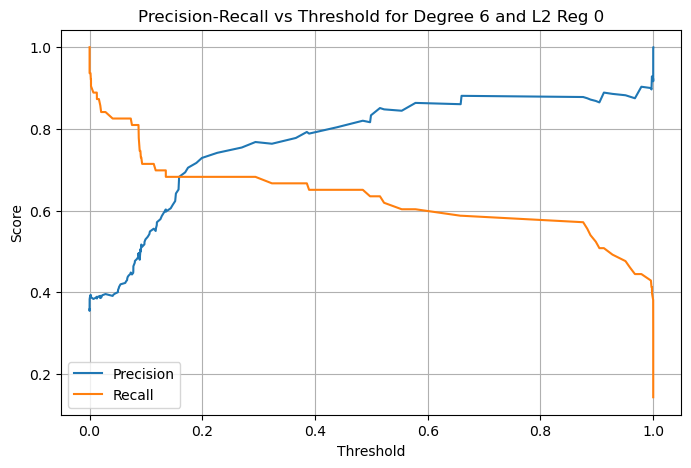

Converged in 595 iterations.

 Validation Set Results for Degree 7

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8182
Precision      : 0.7925
Recall         : 0.6667
F1 Score       : 0.7241
Confusion Matrix:
 [[102  11]
 [ 21  42]]


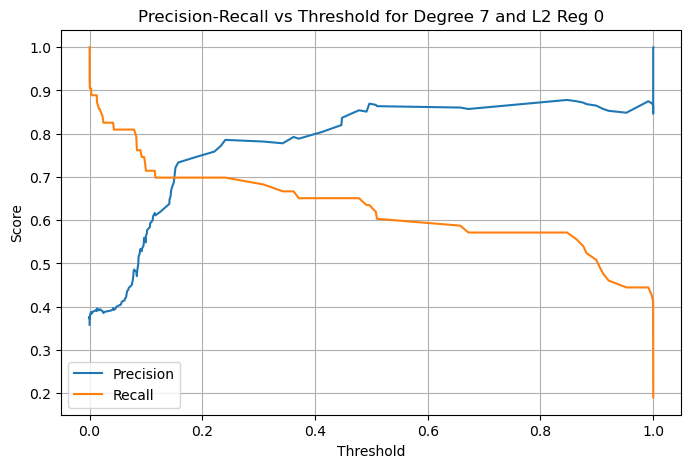

Converged in 959 iterations.

 Validation Set Results for Degree 8

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8239
Precision      : 0.8077
Recall         : 0.6667
F1 Score       : 0.7304
Confusion Matrix:
 [[103  10]
 [ 21  42]]


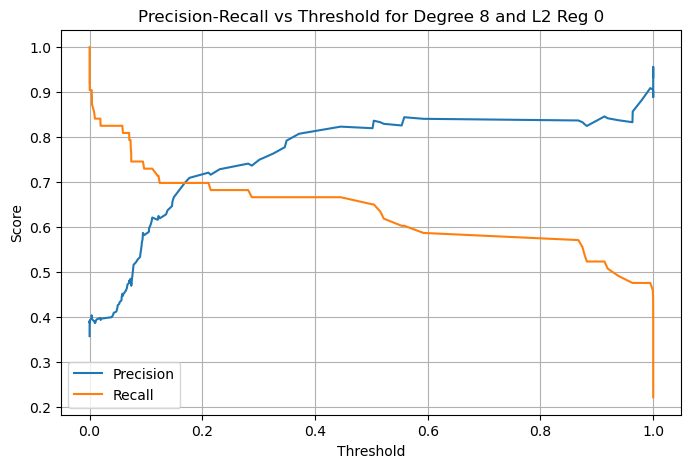


Training with L2 Regularization: 0.01
Converged in 177 iterations.

 Validation Set Results for Degree 1

📊 Classification Metrics (Validation Set):
Accuracy       : 0.7841
Precision      : 0.6984
Recall         : 0.6984
F1 Score       : 0.6984
Confusion Matrix:
 [[94 19]
 [19 44]]


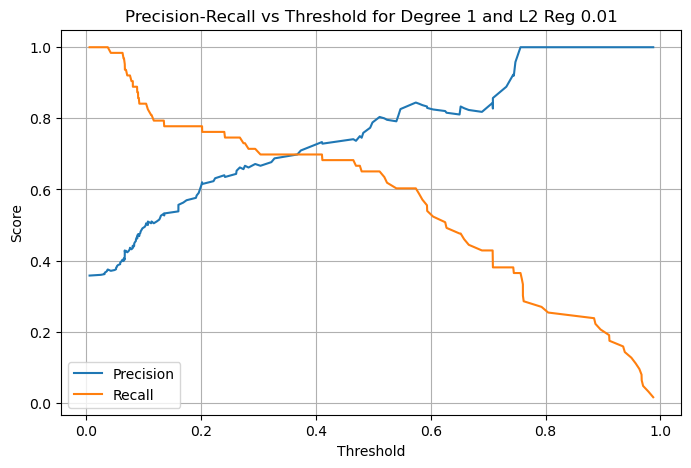

Converged in 4265 iterations.

 Validation Set Results for Degree 2

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8466
Precision      : 0.8103
Recall         : 0.7460
F1 Score       : 0.7769
Confusion Matrix:
 [[102  11]
 [ 16  47]]


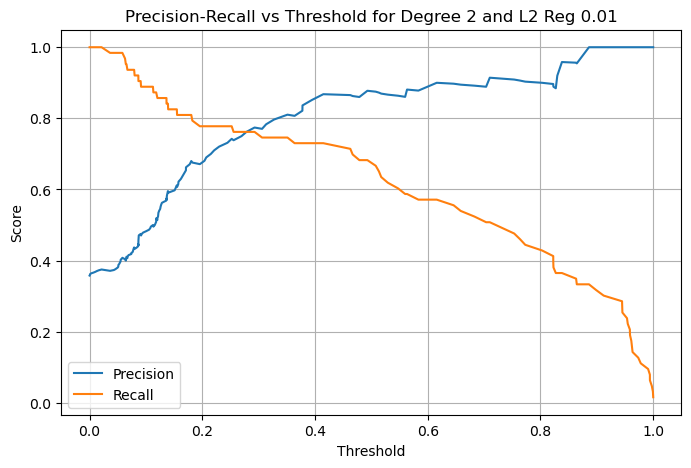

Converged in 5707 iterations.

 Validation Set Results for Degree 3

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8125
Precision      : 0.7679
Recall         : 0.6825
F1 Score       : 0.7227
Confusion Matrix:
 [[100  13]
 [ 20  43]]


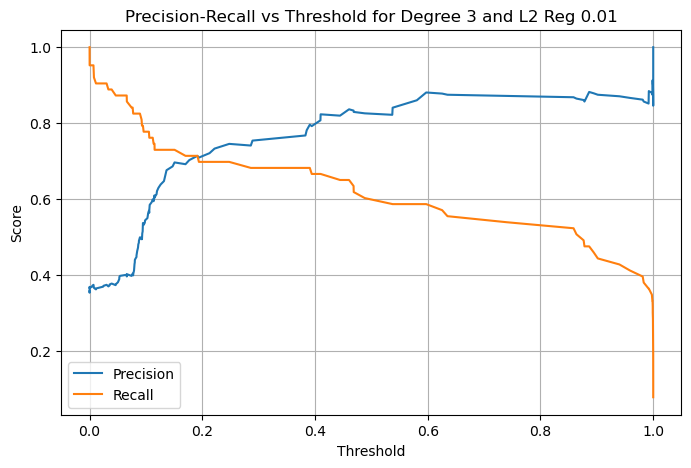

Converged in 2460 iterations.

 Validation Set Results for Degree 4

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8239
Precision      : 0.8077
Recall         : 0.6667
F1 Score       : 0.7304
Confusion Matrix:
 [[103  10]
 [ 21  42]]


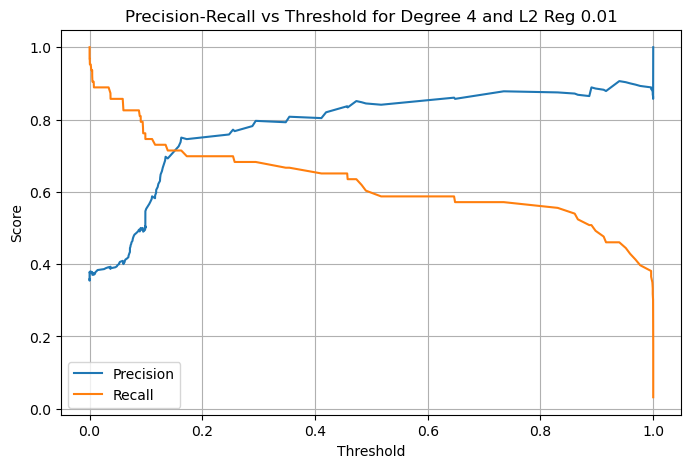

Converged in 1022 iterations.

 Validation Set Results for Degree 5

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8125
Precision      : 0.7778
Recall         : 0.6667
F1 Score       : 0.7179
Confusion Matrix:
 [[101  12]
 [ 21  42]]


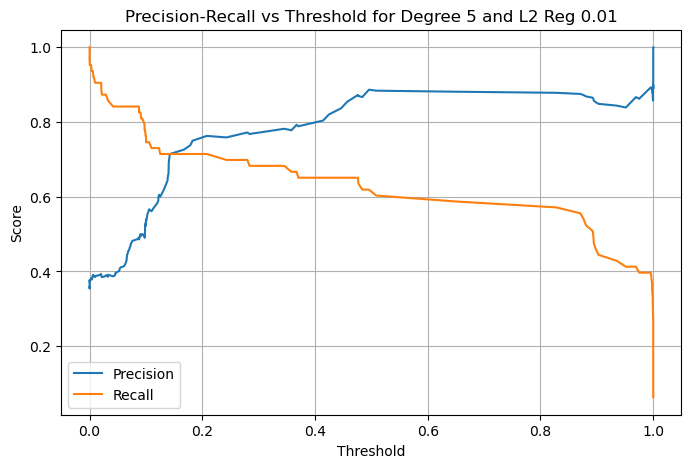

Converged in 1182 iterations.

 Validation Set Results for Degree 6

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8182
Precision      : 0.8039
Recall         : 0.6508
F1 Score       : 0.7193
Confusion Matrix:
 [[103  10]
 [ 22  41]]


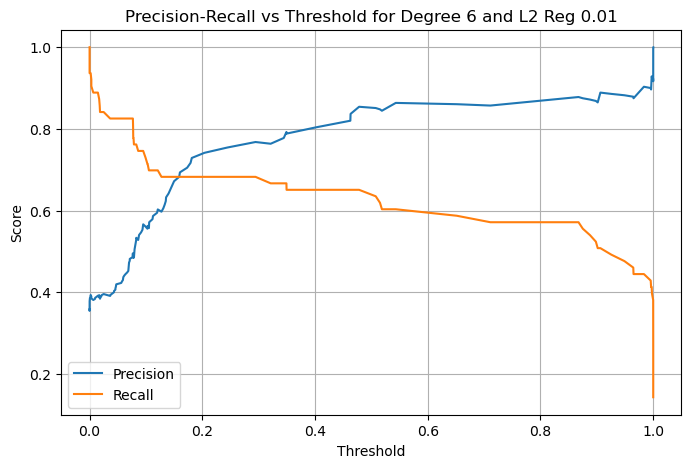

Converged in 603 iterations.

 Validation Set Results for Degree 7

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8182
Precision      : 0.7925
Recall         : 0.6667
F1 Score       : 0.7241
Confusion Matrix:
 [[102  11]
 [ 21  42]]


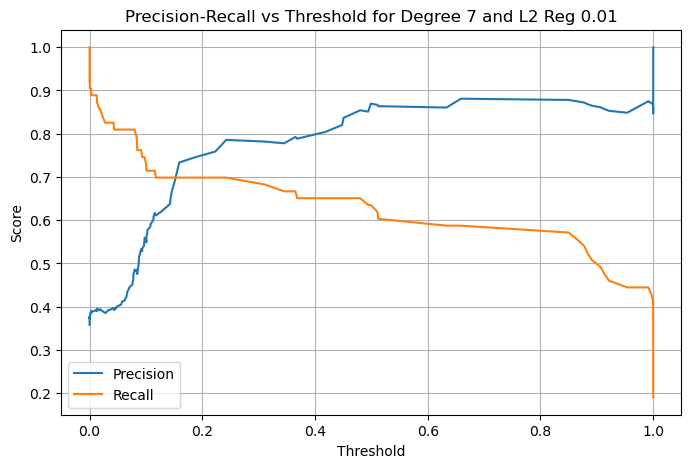

Converged in 940 iterations.

 Validation Set Results for Degree 8

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8182
Precision      : 0.7925
Recall         : 0.6667
F1 Score       : 0.7241
Confusion Matrix:
 [[102  11]
 [ 21  42]]


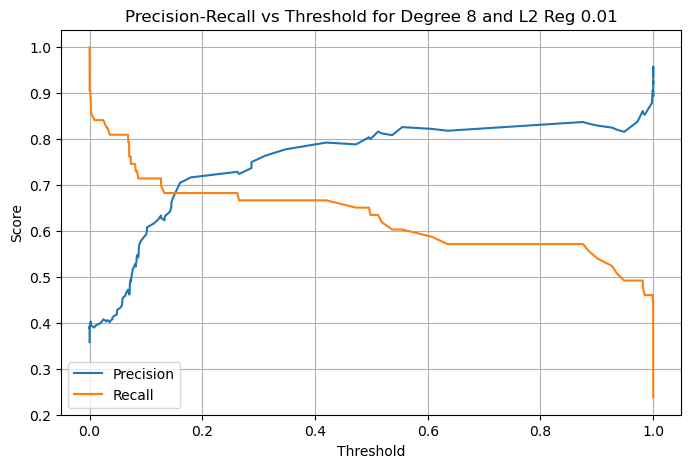


Training with L2 Regularization: 0.1
Converged in 178 iterations.

 Validation Set Results for Degree 1

📊 Classification Metrics (Validation Set):
Accuracy       : 0.7841
Precision      : 0.6984
Recall         : 0.6984
F1 Score       : 0.6984
Confusion Matrix:
 [[94 19]
 [19 44]]


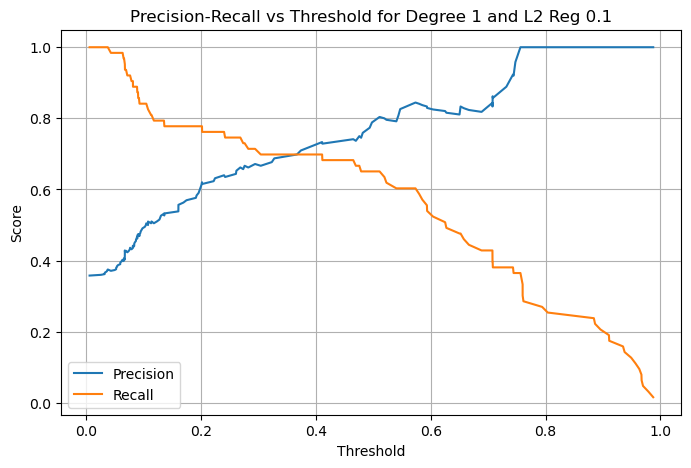

Converged in 3394 iterations.

 Validation Set Results for Degree 2

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8466
Precision      : 0.8103
Recall         : 0.7460
F1 Score       : 0.7769
Confusion Matrix:
 [[102  11]
 [ 16  47]]


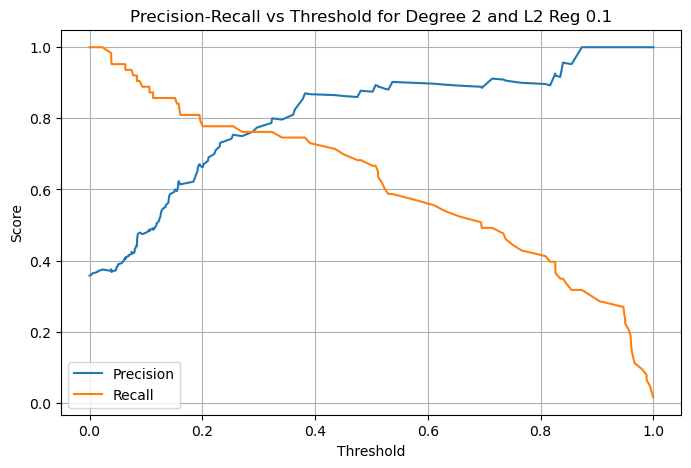

Converged in 4048 iterations.

 Validation Set Results for Degree 3

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8239
Precision      : 0.7963
Recall         : 0.6825
F1 Score       : 0.7350
Confusion Matrix:
 [[102  11]
 [ 20  43]]


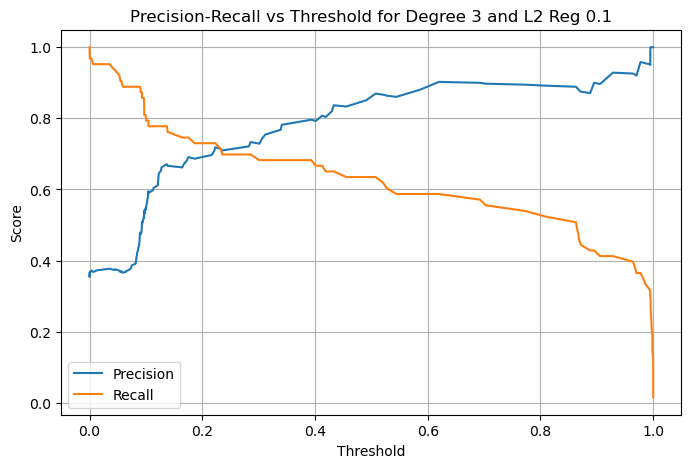

Converged in 2316 iterations.

 Validation Set Results for Degree 4

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8239
Precision      : 0.7963
Recall         : 0.6825
F1 Score       : 0.7350
Confusion Matrix:
 [[102  11]
 [ 20  43]]


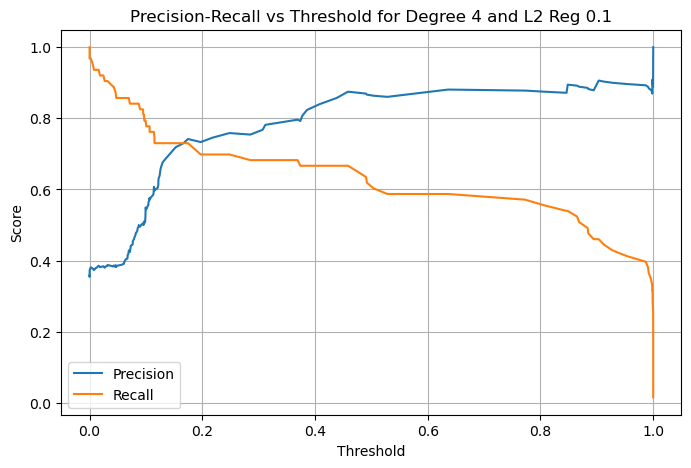

Converged in 955 iterations.

 Validation Set Results for Degree 5

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8125
Precision      : 0.7778
Recall         : 0.6667
F1 Score       : 0.7179
Confusion Matrix:
 [[101  12]
 [ 21  42]]


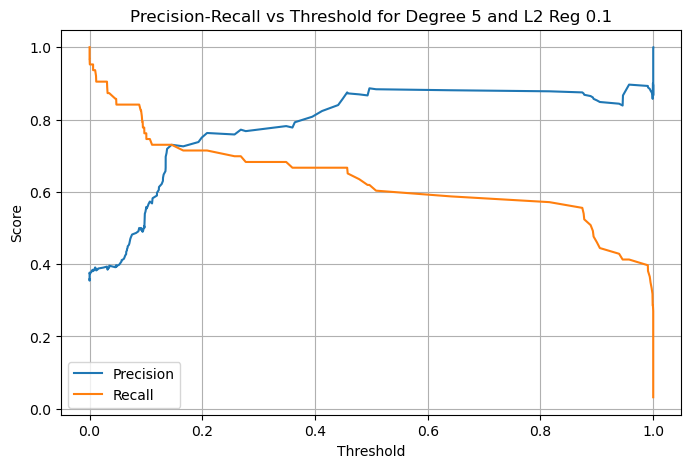

Converged in 1337 iterations.

 Validation Set Results for Degree 6

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8125
Precision      : 0.7885
Recall         : 0.6508
F1 Score       : 0.7130
Confusion Matrix:
 [[102  11]
 [ 22  41]]


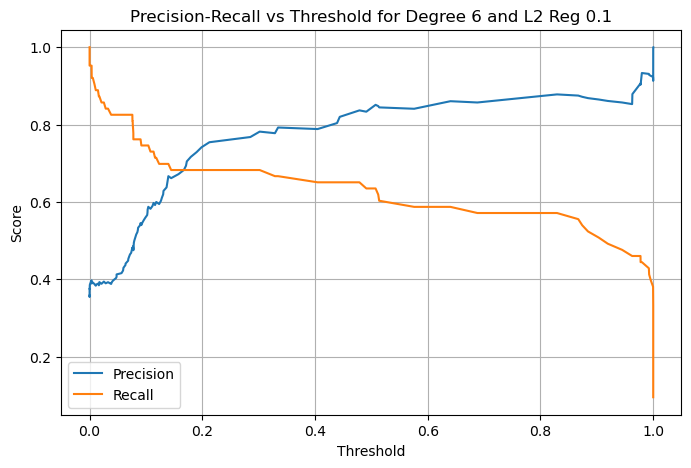

Converged in 790 iterations.

 Validation Set Results for Degree 7

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8239
Precision      : 0.8077
Recall         : 0.6667
F1 Score       : 0.7304
Confusion Matrix:
 [[103  10]
 [ 21  42]]


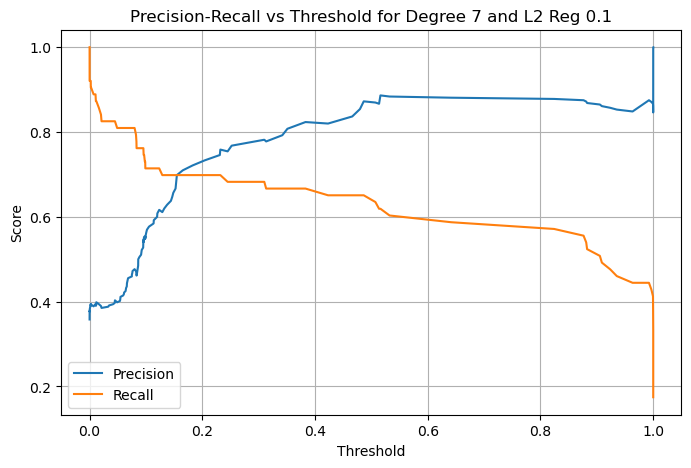

Converged in 2326 iterations.

 Validation Set Results for Degree 8

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8239
Precision      : 0.7963
Recall         : 0.6825
F1 Score       : 0.7350
Confusion Matrix:
 [[102  11]
 [ 20  43]]


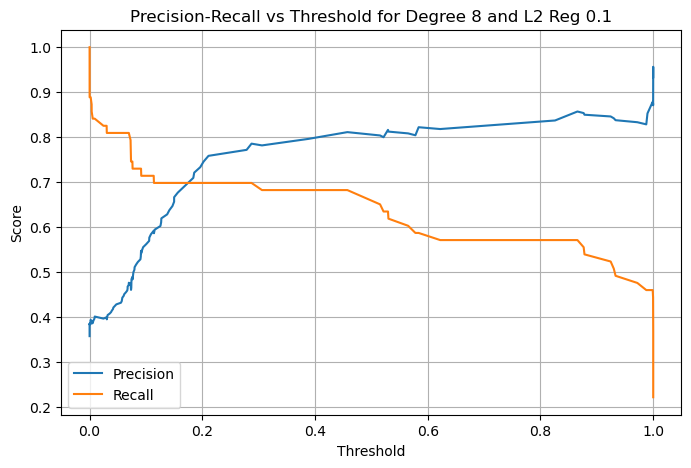


Training with L2 Regularization: 0.5
Converged in 183 iterations.

 Validation Set Results for Degree 1

📊 Classification Metrics (Validation Set):
Accuracy       : 0.7841
Precision      : 0.6984
Recall         : 0.6984
F1 Score       : 0.6984
Confusion Matrix:
 [[94 19]
 [19 44]]


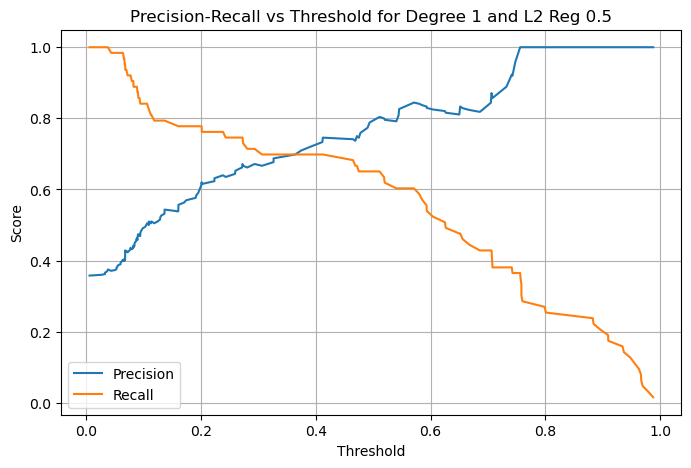

Converged in 1704 iterations.

 Validation Set Results for Degree 2

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8466
Precision      : 0.8214
Recall         : 0.7302
F1 Score       : 0.7731
Confusion Matrix:
 [[103  10]
 [ 17  46]]


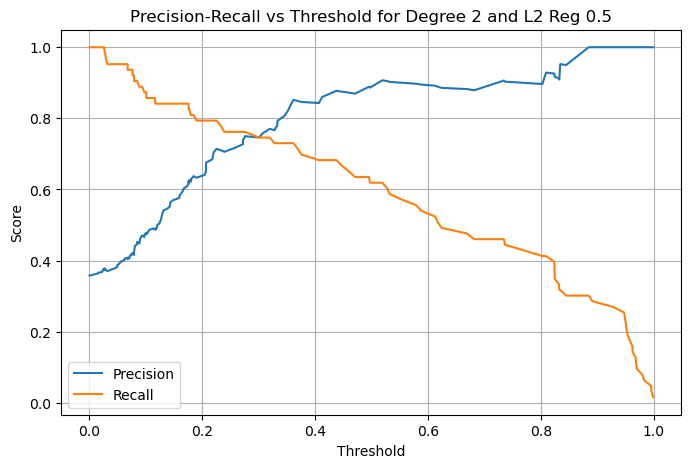

Converged in 2501 iterations.

 Validation Set Results for Degree 3

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8182
Precision      : 0.7925
Recall         : 0.6667
F1 Score       : 0.7241
Confusion Matrix:
 [[102  11]
 [ 21  42]]


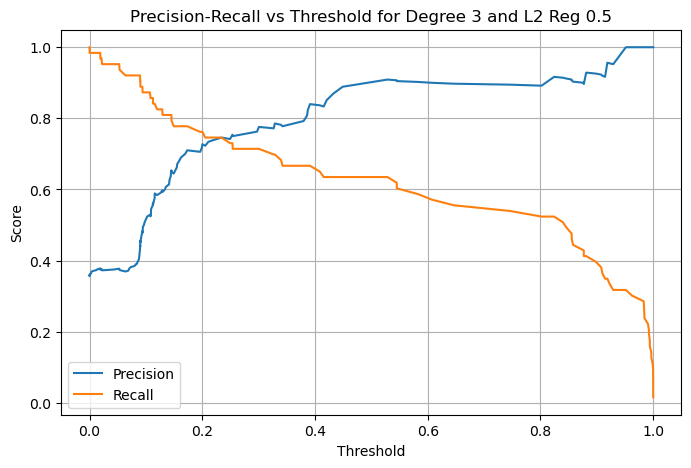

Converged in 2031 iterations.

 Validation Set Results for Degree 4

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8182
Precision      : 0.7818
Recall         : 0.6825
F1 Score       : 0.7288
Confusion Matrix:
 [[101  12]
 [ 20  43]]


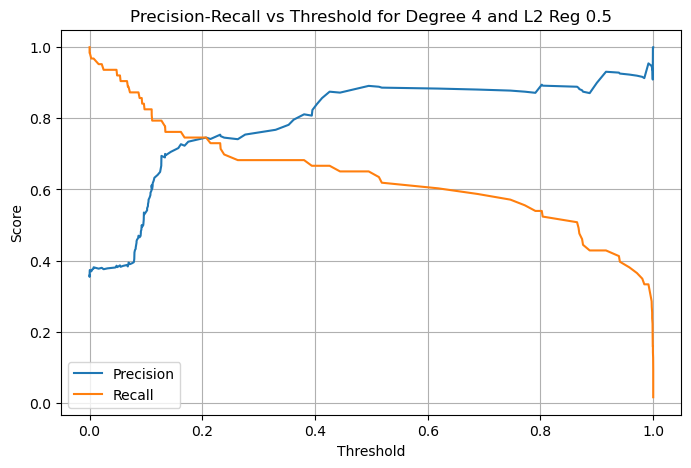

Converged in 895 iterations.

 Validation Set Results for Degree 5

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8239
Precision      : 0.7963
Recall         : 0.6825
F1 Score       : 0.7350
Confusion Matrix:
 [[102  11]
 [ 20  43]]


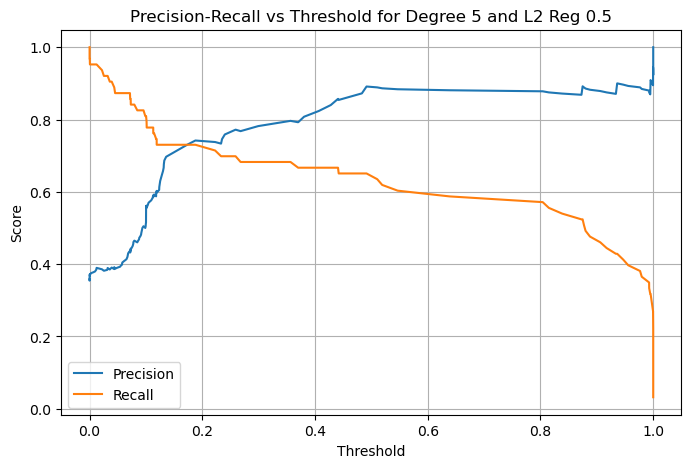

Converged in 225 iterations.

 Validation Set Results for Degree 6

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8068
Precision      : 0.7636
Recall         : 0.6667
F1 Score       : 0.7119
Confusion Matrix:
 [[100  13]
 [ 21  42]]


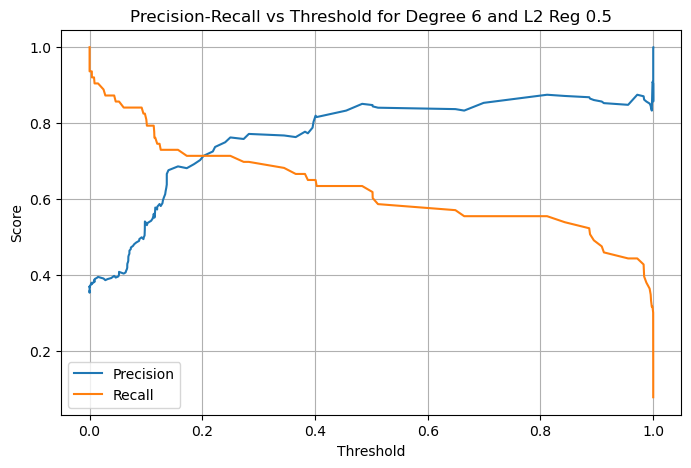

Converged in 829 iterations.

 Validation Set Results for Degree 7

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8295
Precision      : 0.8235
Recall         : 0.6667
F1 Score       : 0.7368
Confusion Matrix:
 [[104   9]
 [ 21  42]]


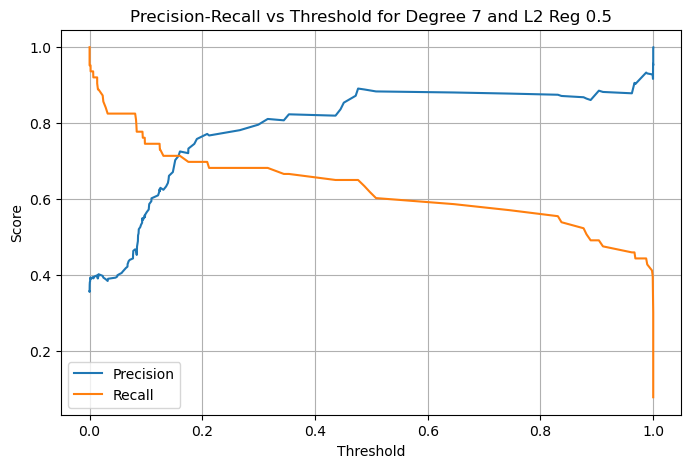

Converged in 849 iterations.

 Validation Set Results for Degree 8

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8239
Precision      : 0.8077
Recall         : 0.6667
F1 Score       : 0.7304
Confusion Matrix:
 [[103  10]
 [ 21  42]]


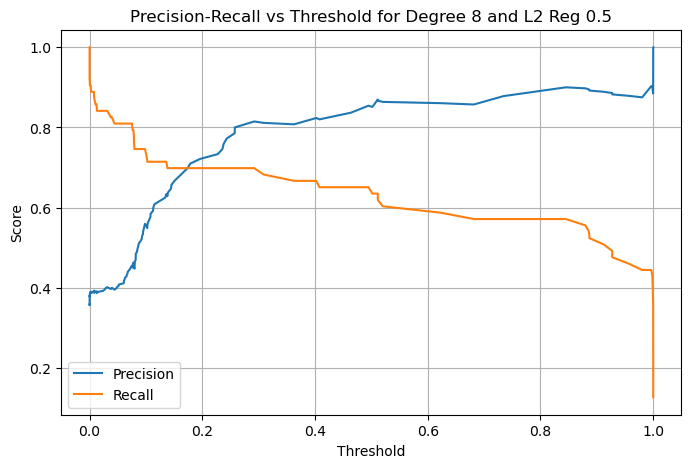


Training with L2 Regularization: 0.75
Converged in 185 iterations.

 Validation Set Results for Degree 1

📊 Classification Metrics (Validation Set):
Accuracy       : 0.7841
Precision      : 0.6984
Recall         : 0.6984
F1 Score       : 0.6984
Confusion Matrix:
 [[94 19]
 [19 44]]


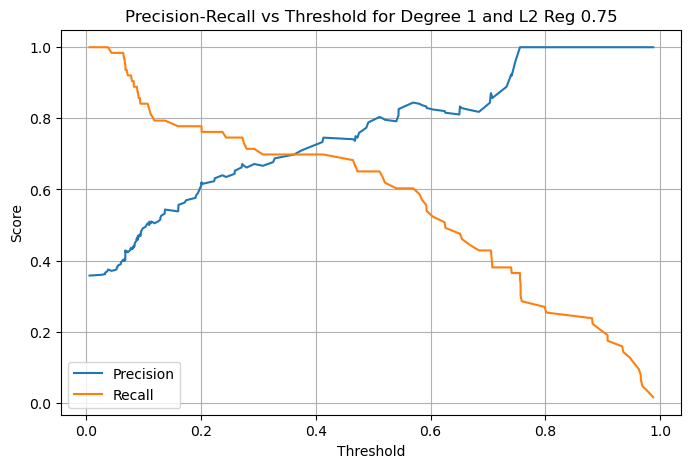

Converged in 1479 iterations.

 Validation Set Results for Degree 2

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8466
Precision      : 0.8214
Recall         : 0.7302
F1 Score       : 0.7731
Confusion Matrix:
 [[103  10]
 [ 17  46]]


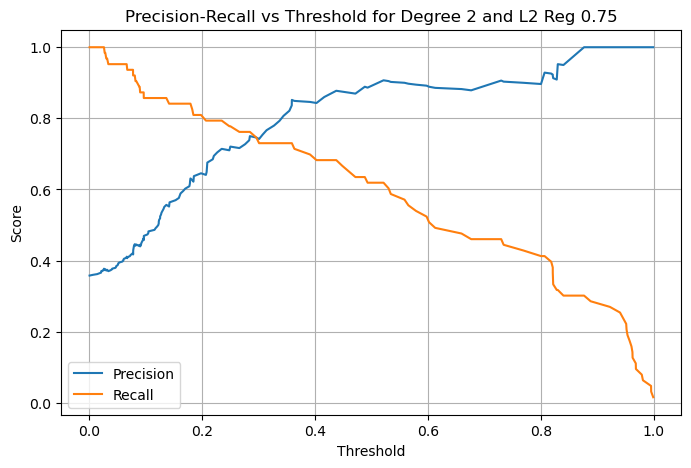

Converged in 2210 iterations.

 Validation Set Results for Degree 3

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8239
Precision      : 0.7963
Recall         : 0.6825
F1 Score       : 0.7350
Confusion Matrix:
 [[102  11]
 [ 20  43]]


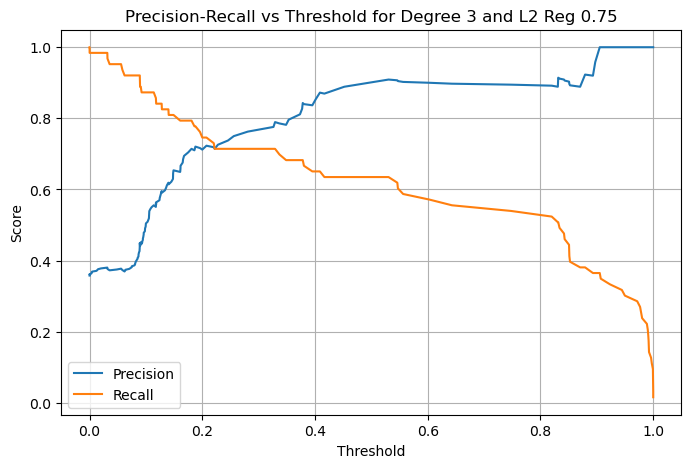

Converged in 1748 iterations.

 Validation Set Results for Degree 4

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8239
Precision      : 0.7963
Recall         : 0.6825
F1 Score       : 0.7350
Confusion Matrix:
 [[102  11]
 [ 20  43]]


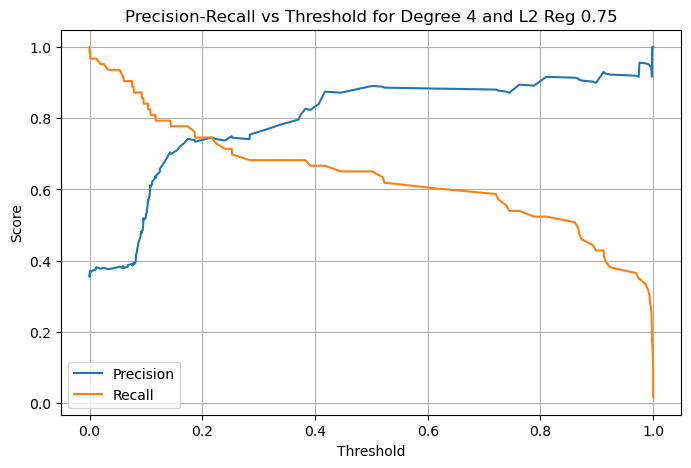

Converged in 880 iterations.

 Validation Set Results for Degree 5

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8239
Precision      : 0.7963
Recall         : 0.6825
F1 Score       : 0.7350
Confusion Matrix:
 [[102  11]
 [ 20  43]]


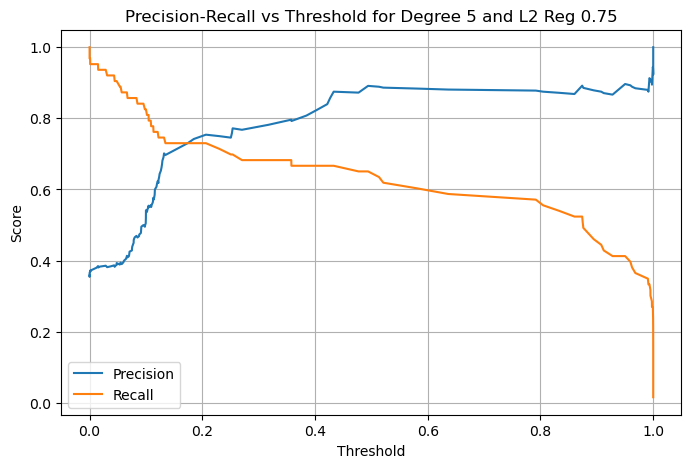

Converged in 762 iterations.

 Validation Set Results for Degree 6

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8068
Precision      : 0.7736
Recall         : 0.6508
F1 Score       : 0.7069
Confusion Matrix:
 [[101  12]
 [ 22  41]]


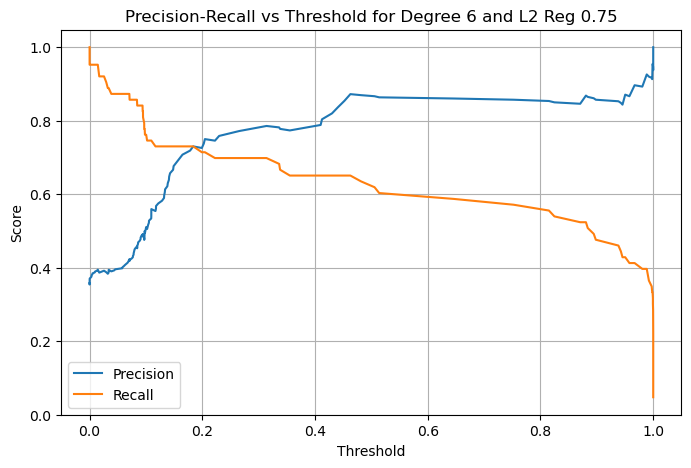

Converged in 994 iterations.

 Validation Set Results for Degree 7

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8295
Precision      : 0.8367
Recall         : 0.6508
F1 Score       : 0.7321
Confusion Matrix:
 [[105   8]
 [ 22  41]]


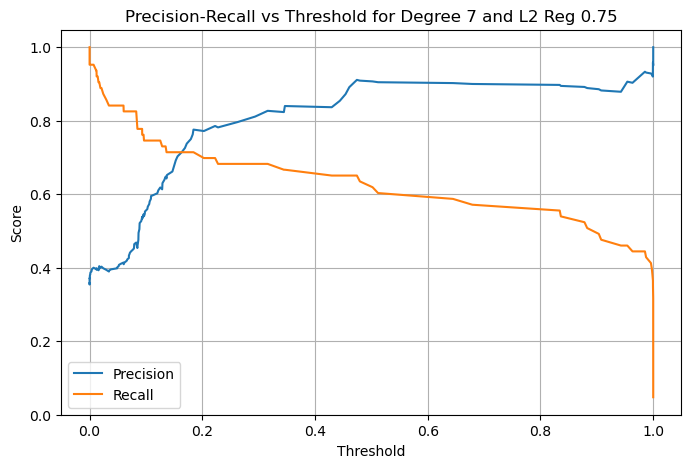

Converged in 588 iterations.

 Validation Set Results for Degree 8

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8239
Precision      : 0.8077
Recall         : 0.6667
F1 Score       : 0.7304
Confusion Matrix:
 [[103  10]
 [ 21  42]]


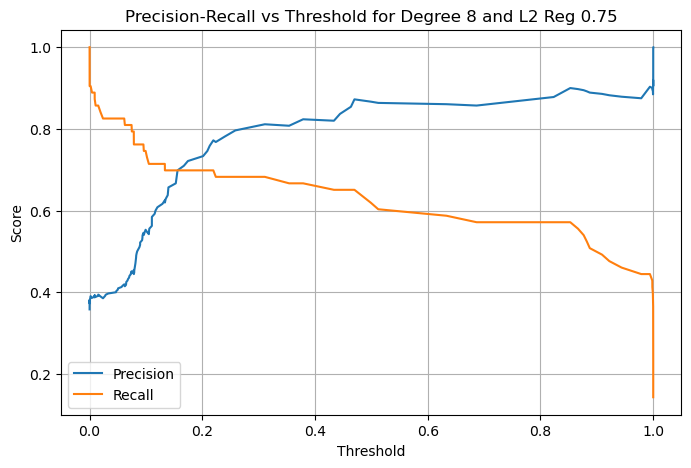


Training with L2 Regularization: 1.0
Converged in 187 iterations.

 Validation Set Results for Degree 1

📊 Classification Metrics (Validation Set):
Accuracy       : 0.7841
Precision      : 0.6984
Recall         : 0.6984
F1 Score       : 0.6984
Confusion Matrix:
 [[94 19]
 [19 44]]


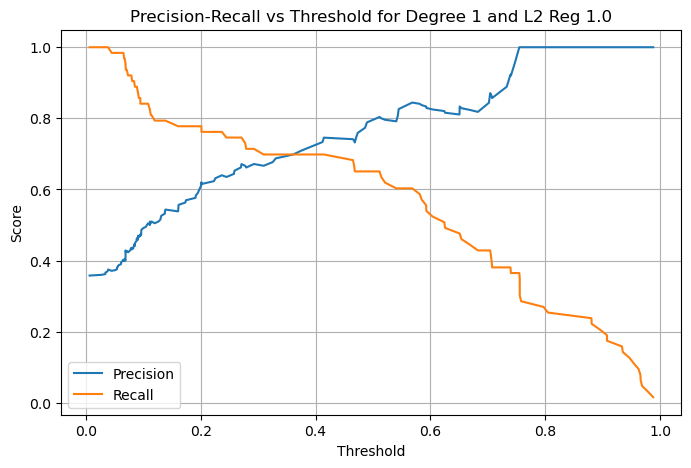

Converged in 1351 iterations.

 Validation Set Results for Degree 2

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8466
Precision      : 0.8214
Recall         : 0.7302
F1 Score       : 0.7731
Confusion Matrix:
 [[103  10]
 [ 17  46]]


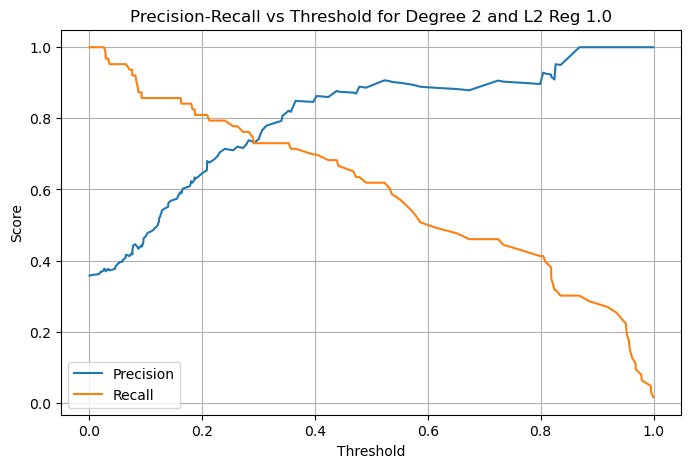

Converged in 2021 iterations.

 Validation Set Results for Degree 3

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8239
Precision      : 0.7963
Recall         : 0.6825
F1 Score       : 0.7350
Confusion Matrix:
 [[102  11]
 [ 20  43]]


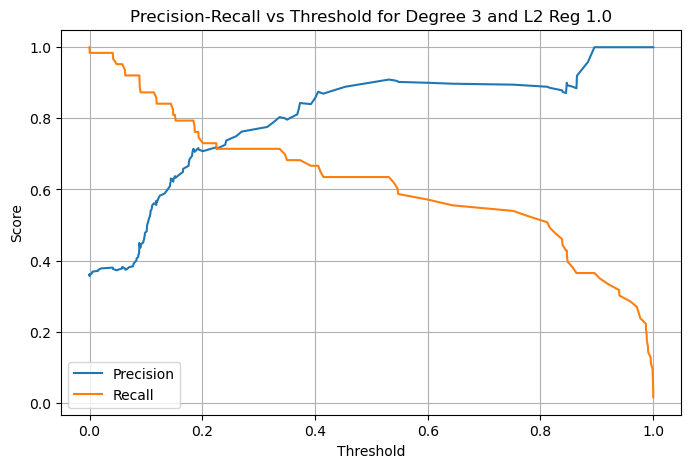

Converged in 1573 iterations.

 Validation Set Results for Degree 4

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8239
Precision      : 0.7963
Recall         : 0.6825
F1 Score       : 0.7350
Confusion Matrix:
 [[102  11]
 [ 20  43]]


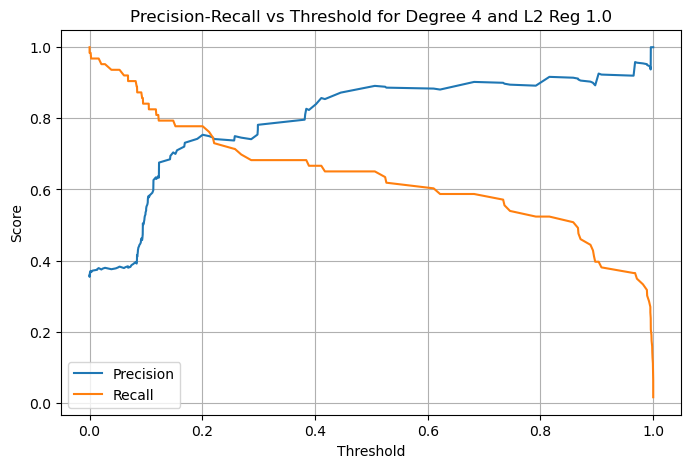

Converged in 872 iterations.

 Validation Set Results for Degree 5

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8295
Precision      : 0.8113
Recall         : 0.6825
F1 Score       : 0.7414
Confusion Matrix:
 [[103  10]
 [ 20  43]]


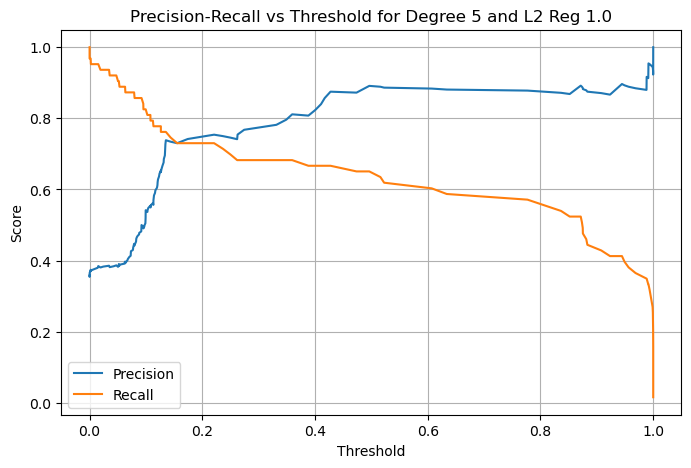

Converged in 648 iterations.

 Validation Set Results for Degree 6

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8125
Precision      : 0.7778
Recall         : 0.6667
F1 Score       : 0.7179
Confusion Matrix:
 [[101  12]
 [ 21  42]]


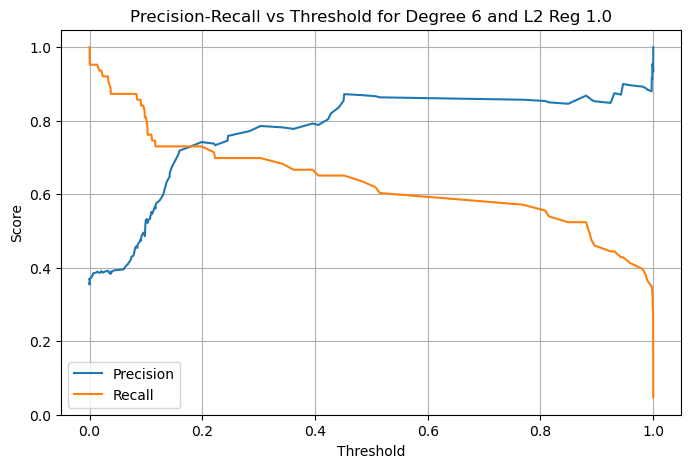

Converged in 1250 iterations.

 Validation Set Results for Degree 7

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8239
Precision      : 0.8200
Recall         : 0.6508
F1 Score       : 0.7257
Confusion Matrix:
 [[104   9]
 [ 22  41]]


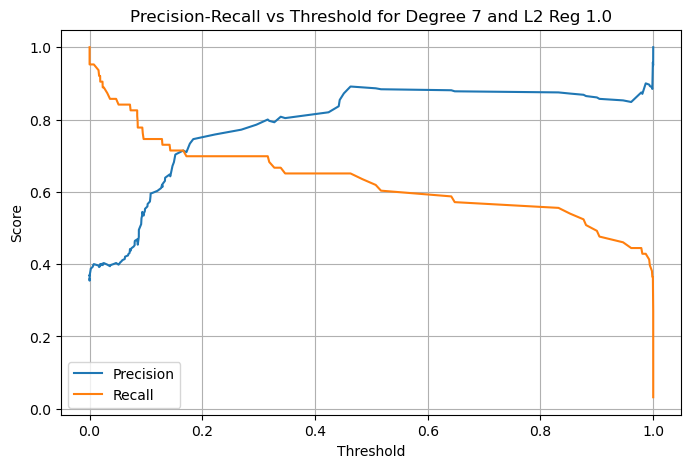

Converged in 469 iterations.

 Validation Set Results for Degree 8

📊 Classification Metrics (Validation Set):
Accuracy       : 0.8182
Precision      : 0.7925
Recall         : 0.6667
F1 Score       : 0.7241
Confusion Matrix:
 [[102  11]
 [ 21  42]]


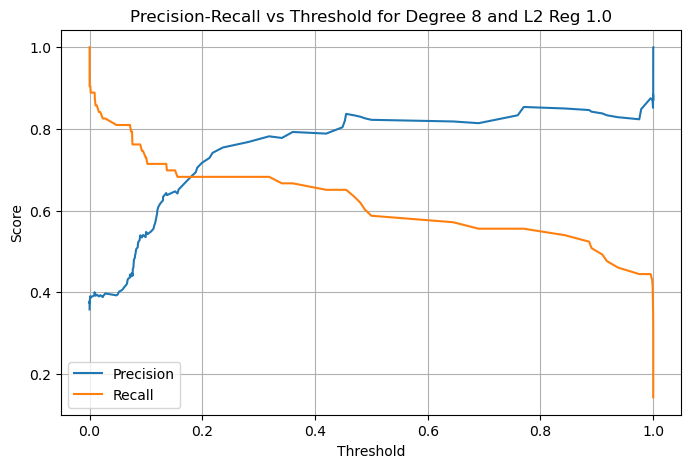

In [28]:
degree = 7
for L2_reg in [0 ,0.01, 0.1, 0.5, 0.75, 1.0]:
    print(f"\nTraining with L2 Regularization: {L2_reg}")
    for degree in range(degree+1):
        # Load data
        df = pd.read_csv("cleaned_titanic_data.csv")

        # Separate features (X) and target (y)
        X = df.drop('Survived', axis=1).values
        y = df['Survived'].values.reshape(-1, 1)

        X = polynomial_features(X, degree+1)

        # Step 1: Shuffle the data
        np.random.seed(42)  # for reproducibility
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)

        X = X[indices]
        y = y[indices]


        # Step 2: 60% for training set, 40% for validation and test sets
        split_index = int(0.6 * X.shape[0])
        X_train, X_ = X[:split_index], X[split_index:]
        y_train, y_ = y[:split_index], y[split_index:]

        #20% for validation and 20% for test set
        split_index = int(0.5 * X_.shape[0])
        X_test, X_val = X_[split_index:], X_[:split_index]
        y_test, y_val = y_[split_index:], y_[:split_index]

        # Step 3: Z-score normalization (standardization) for X
        mean = np.mean(X_train, axis=0)
        std = np.std(X_train, axis=0)

        # Avoid division by zero
        std[std == 0] = 1.0

        X_train_scaled = (X_train - mean) / std
        X_test_scaled = (X_test - mean) / std  # use train mean & std!

        X_val_scaled = (X_val - mean) / std  # use train mean & std!
        X_test_scaled = (X_test - mean) / std  # use train mean & std!

        # Step 4: Initialize parameters
        m, n = X_train_scaled.shape
        w = np.random.uniform(low=-1.0, high=1.0, size=(n, 1))
        b = 0.0

        wf, bf = gradient_descent(
        0.01,
        X_train_scaled,
        y_train,
        w,
        b,
        L2_reg,
        method='adam',  # 'vanilla' or 'adam'
        previous_cost=compute_cost(X_train, y_train, w, b),
        threshold=1e-6,
        max_iters=1000000
        )

        y_pred_val = predict(X_val_scaled, wf, bf)  # Use your predict function


        # Compute classification metrics
        acc = accuracy_score(y_val, y_pred_val)
        prec = precision_score(y_val, y_pred_val)
        rec = recall_score(y_val, y_pred_val)
        f1 = f1_score(y_val, y_pred_val)
        cm = confusion_matrix(y_val, y_pred_val)
        print("\n Validation Set Results for Degree", degree + 1)
        # Print results
        print("\n📊 Classification Metrics (Validation Set):")
        print(f"Accuracy       : {acc:.4f}")
        print(f"Precision      : {prec:.4f}")
        print(f"Recall         : {rec:.4f}")
        print(f"F1 Score       : {f1:.4f}")
        print("Confusion Matrix:\n", cm)

        y_prob_val = predict_prob(X_val_scaled, wf, bf)
        
        # Get precision, recall, and thresholds
        precisions, recalls, thresholds = precision_recall_curve(y_val, y_prob_val)

        # Plot the curve
        plt.figure(figsize=(8, 5))
        plt.plot(thresholds, precisions[:-1], label="Precision")
        plt.plot(thresholds, recalls[:-1], label="Recall")
        plt.xlabel("Threshold")
        plt.ylabel("Score")
        plt.title(f"Precision-Recall vs Threshold for Degree {degree + 1} and L2 Reg {L2_reg}")
        plt.legend()
        plt.grid(True)
        plt.show()


### **🔍 Metric Definitions**
Accuracy: Overall percentage of correct predictions.

Precision: Proportion of predicted positives that were actually positive.

Recall: Proportion of actual positives that were correctly predicted.

F1 Score: Harmonic mean of precision and recall — balances the two.

### **🧠 Key Observations**
Degree 1 performs well with a simple linear model, achieving good metrics, but misses some nonlinear patterns.

Degree 2 gives the best F1 score (0.7769) and highest accuracy (84.66%), striking an excellent balance between precision and recall.

Other models did good but didnt not outperform Degree 2.

With slight modification to the threshold (.35 ---> .375) even better performance can be achieved.

### **🏆 Conclusion**
Polynomial degree 2 is the optimal choice in this setup, balancing generalization, simplicity, and performance.

It captures essential non-linearities without overfitting.

Higher degrees offer marginal improvements but introduce complexity and overfitting risk.

### **📌 Future Work**
✅ Compare with scikit-learn’s LogisticRegression

✅ Deploying best-performing model to Hugging Face 🤗 spaces

In [35]:
df = pd.read_csv("cleaned_titanic_data.csv")

# Separate features (X) and target (y)
X = df.drop('Survived', axis=1).values
y = df['Survived'].values.reshape(-1, 1)

X = polynomial_features(X, degree=2)

# Step 1: Shuffle the data
np.random.seed(42)  # for reproducibility
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
y = y[indices]


# Step 2: 60% for training set, 40% for validation and test sets
split_index = int(0.6 * X.shape[0])
X_train, X_ = X[:split_index], X[split_index:]
y_train, y_ = y[:split_index], y[split_index:]

#20% for validation and 20% for test set
split_index = int(0.5 * X_.shape[0])
X_test, X_val = X_[split_index:], X_[:split_index]
y_test, y_val = y_[split_index:], y_[:split_index]

# Step 3: Z-score normalization (standardization) for X
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

# Avoid division by zero
std[std == 0] = 1.0

X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std  # use train mean & std!
X_val_scaled = (X_val - mean) / std  # use train mean & std!

# Step 4: Initialize parameters
m, n = X_train_scaled.shape
w = np.random.uniform(low=-1.0, high=1.0, size=(n, 1))
b = 0.0

wf, bf = gradient_descent(
0.01,
X_train_scaled,
y_train,
w,
b,
L2_reg=0.1,
method='adam',  # 'vanilla' or 'adam'
previous_cost=compute_cost(X_train, y_train, w, b),
threshold=1e-6,
max_iters=1000000
)

y_pred_test = predict(X_test_scaled, wf, bf)  # Use your predict function


# Compute classification metrics
acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
cm = confusion_matrix(y_test, y_pred_test)
print("\n Validation Set Results for Degree 2")
# Print results
print("\n📊 Classification Metrics (Validation Set):")
print(f"Accuracy       : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1 Score       : {f1:.4f}")
print("Confusion Matrix:\n", cm)

Converged in 3394 iterations.

 Validation Set Results for Degree 2

📊 Classification Metrics (Validation Set):
Accuracy       : 0.7401
Precision      : 0.7143
Recall         : 0.6579
F1 Score       : 0.6849
Confusion Matrix:
 [[81 20]
 [26 50]]


## Final Model Evaluation (Degree 2 Polynomial Features)

After selecting the degree 2 polynomial model based on validation set performance,
we retrained the model on the full 80% of data (train + validation) and evaluated on the held-out 20% test set.

### ✅ Validation Set Metrics
- Accuracy: 84.66%
- Precision: 81.03%
- Recall: 74.6%
- F1 Score: 77.69%
- Confusion Matrix: [[102, 11], [16, 47]]

### 🧪 Test Set Metrics (Final Evaluation)
- Accuracy: 74.01%
- Precision: 71.43%
- Recall: 65.79%
- F1 Score: 68.49%
- Confusion Matrix: [[81, 20], [26, 50]]

### 🔍 Interpretation
- The model experienced a performance drop when evaluated on the unseen test set.
- This is expected and highlights the importance of final testing after model selection.
- Despite the drop, the model generalizes reasonably well, with strong precision and acceptable recall.
- Compared to the non regularized version in 'Traditional/' directory this had higher F1 score.

### 📌 Final Verdict
Degree 2 was selected as the optimal model due to its balance of performance and simplicity.
The results on the test set confirm its ability to generalize with room for further improvement (e.g. regularization, more data, or tuning thresholds).

# **Training Final Model Parameters for Deployment**

Iteration 0 | Cost: 1.85886 | b: -0.01000
Iteration 100 | Cost: 0.42876 | b: -0.50303
Iteration 200 | Cost: 0.38951 | b: -0.62276
Iteration 300 | Cost: 0.37948 | b: -0.62049
Iteration 400 | Cost: 0.37458 | b: -0.59704
Iteration 500 | Cost: 0.37157 | b: -0.58711
Iteration 600 | Cost: 0.36950 | b: -0.58523
Iteration 700 | Cost: 0.36796 | b: -0.58733
Iteration 800 | Cost: 0.36675 | b: -0.59134
Iteration 900 | Cost: 0.36577 | b: -0.59617
Iteration 1000 | Cost: 0.36496 | b: -0.60127
Iteration 1100 | Cost: 0.36426 | b: -0.60633
Iteration 1200 | Cost: 0.36365 | b: -0.61120
Iteration 1300 | Cost: 0.36311 | b: -0.61576
Iteration 1400 | Cost: 0.36263 | b: -0.61994
Iteration 1500 | Cost: 0.36219 | b: -0.62368
Iteration 1600 | Cost: 0.36179 | b: -0.62695
Iteration 1700 | Cost: 0.36141 | b: -0.62975
Iteration 1800 | Cost: 0.36106 | b: -0.63207
Iteration 1900 | Cost: 0.36073 | b: -0.63395
Iteration 2000 | Cost: 0.36042 | b: -0.63540
Iteration 2100 | Cost: 0.36012 | b: -0.63647
Iteration 2200 | Cost:

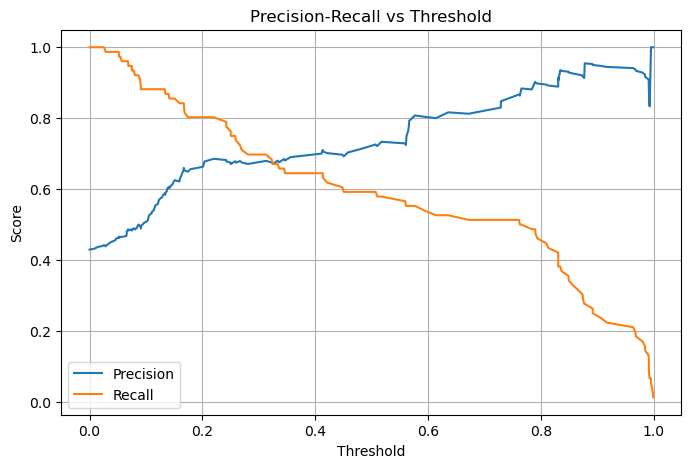

In [ ]:
df = pd.read_csv("cleaned_titanic_data.csv")

# Separate features (X) and target (y)
X = df.drop('Survived', axis=1).values
y = df['Survived'].values.reshape(-1, 1)

X = polynomial_features(X, degree=2)

# Step 1: Shuffle the data
np.random.seed(42)  # for reproducibility
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
y = y[indices]


# Step 2: 80% for training set, 20% for validation and test sets
split_index = int(0.8 * X.shape[0])
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


# Step 3: Z-score normalization (standardization) for X
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

# Avoid division by zero
std[std == 0] = 1.0

X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std  # use train mean & std!

# Step 4: Initialize parameters
m, n = X_train_scaled.shape
w = np.random.uniform(low=-1.0, high=1.0, size=(n, 1))
b = 0.0

wf, bf = gradient_descent(
0.01,
X_train_scaled,
y_train,
w,
b,
L2_reg=0.1,
method='adam',  # 'vanilla' or 'adam'
previous_cost=compute_cost(X_train, y_train, w, b),
threshold=1e-6,
max_iters=1000000
)

y_pred_test = predict(X_test_scaled, wf, bf)  # Use your predict function


# Compute classification metrics
acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
cm = confusion_matrix(y_test, y_pred_test)
print("\n Validation Set Results for Degree 2")
# Print results
print("\n📊 Classification Metrics (Validation Set):")
print(f"Accuracy       : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1 Score       : {f1:.4f}")
print("Confusion Matrix:\n", cm)


y_prob_test = predict_prob(X_test_scaled, wf, bf)

# Get precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_test)

# Plot the curve
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

### **Saving Model Parameters**

In [ ]:
#save_weights_to_npy(wf, bf, std, mean)

In [ ]:
#Converting logs to DataFrame
df_log = pd.DataFrame({
    'iteration': iteration_log,
    'cost': cost_log,
    'bias': bias_log,
})

#Saving log
#df_log.to_csv('gd_convergence_log.csv', index=False)